In [1]:
import os
import re
import sys
from collections import defaultdict
from functools import reduce, partial
from io import StringIO

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import skbio
from skbio import diversity
from skbio.stats import ordination

In [2]:
otus = pd.read_csv("../data/eugene/otusy_otfiltrovannye.csv", sep=";", comment="#").drop_duplicates()
otus

,sample_name,cluster_id,cluster_acc,n_seqs,avg_seq_ident,similarity,sequence,reference,classifications,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,v220,23508,M01197:116:000000000-DHGG8:1:1101:10037:13136,66,99.42,99.80,TACGGGGGGAGCAAGCGTTGTTCGGATTTACTGGGCGTAAAGGGCG...,KF037415.1.1527,ncbi|138.1|77133|root,cellular organisms,...,Pyrinomonadales,Pyrinomonadaceae,RB41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,v220,24545,M01197:116:000000000-DHGG8:1:1101:16354:7724,4,100.00,100.00,TACGGGGGGAGCAAGCGTTGTTCGGATTTACTGGGCGTAAAGGGCG...,KY190395.1.1482,ncbi|138.1|77133|root,cellular organisms,...,Pyrinomonadales,Pyrinomonadaceae,RB41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,v220,27585,M01197:116:000000000-DHGG8:1:1102:12666:6930,3,98.60,99.80,TACGGGGGGAGCAAGCGTTGTTCGGATTTACTGGGCGTAAAGGGCG...,HM224426.1.1489,ncbi|138.1|77133|root,cellular organisms,...,Pyrinomonadales,Pyrinomonadaceae,RB41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,v225,57242,M01197:116:000000000-DHGG8:1:1102:14470:26289,1,100.00,97.01,TACGGGGGGAGCAAGCGTTGTTCGGATTTACTGGGCGTAAAGGGCG...,JN616042.1.1383,ncbi|138.1|77133|root,cellular organisms,...,Pyrinomonadales,Pyrinomonadaceae,RB41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,v225,59239,M01197:116:000000000-DHGG8:1:1102:22752:11318,2,100.00,100.00,TACGGGGGGAGCAAGCGTTGTTCGGATTTACTGGGCGTAAAGGGCG...,JF429059.1.1529,ncbi|138.1|77133|root,cellular organisms,...,Pyrinomonadales,Pyrinomonadaceae,RB41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2073,v219,22551,M01197:116:000000000-DHGG8:1:1102:18468:7619,1,100.00,100.00,TACGAAGGTCCCAAGCGTTGTTCGGAATCACTGGGCGTAAAGGGAG...,KF799162.1.1415,ncbi|138.1|77133|root,cellular organisms,...,Verrucomicrobiales,Rubritaleaceae,Luteolibacter,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2074,v223,38720,M01197:116:000000000-DHGG8:1:1102:7732:18035,1,100.00,95.50,TACGAAGGTCCCAAGCGTTGTTCGGAATCACTGGGCGTAAAGGGAG...,FJ716028.1.1413,ncbi|138.1|77133|root,cellular organisms,...,Verrucomicrobiales,Rubritaleaceae,Luteolibacter,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2075,v225,53935,M01197:116:000000000-DHGG8:1:1101:22808:7682,3,100.00,100.00,TACGAAGGTCCCGAGCGTTGTTCGGAATCACTGGGCGTAAAGGGAG...,EF471653.1.1492,ncbi|138.1|156588|root,cellular organisms,...,Verrucomicrobiales,Rubritaleaceae,Luteolibacter,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2076,v229,80688,M01197:116:000000000-DHGG8:1:1102:6039:20320,1,100.00,99.80,TACGAAGGTCCCGAGCGTTGTTCGGAATCACTGGGCGTAAAGGGAG...,JQ346775.1.1379,ncbi|138.1|156588|root,cellular organisms,...,Verrucomicrobiales,Rubritaleaceae,Luteolibacter,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Distributuions

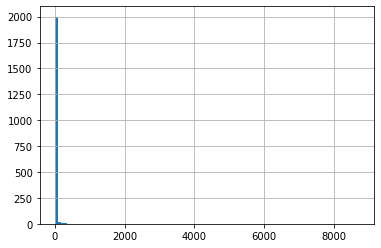

In [30]:
otus.n_seqs.hist(bins=100);

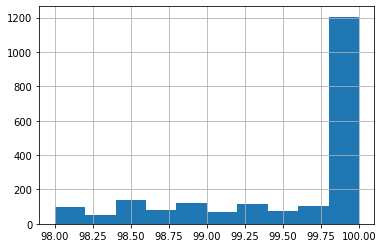

In [31]:
otus.avg_seq_ident.hist();

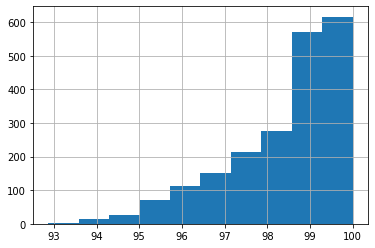

In [32]:
otus.similarity.hist();

### Taxa

In [3]:
otus = otus.rename(columns={"Unnamed: 13": "domain", "Unnamed: 14": "phylum", "Unnamed: 15": "class", "Unnamed: 16": "order", "Unnamed: 17": "family", "Unnamed: 18": "genus"})
otus = otus.drop([c for c in otus.columns if c.startswith("Unnamed")], axis=1)
otus["domain"] = "Bacteria"

In [4]:
otus.head()

,sample_name,cluster_id,cluster_acc,n_seqs,avg_seq_ident,similarity,sequence,reference,classifications,domain,phylum,class,order,family,genus
0,v220,23508,M01197:116:000000000-DHGG8:1:1101:10037:13136,66,99.42,99.80,TACGGGGGGAGCAAGCGTTGTTCGGATTTACTGGGCGTAAAGGGCG...,KF037415.1.1527,ncbi|138.1|77133|root,Bacteria,Acidobacteriota,Blastocatellia,Pyrinomonadales,Pyrinomonadaceae,RB41
1,v220,24545,M01197:116:000000000-DHGG8:1:1101:16354:7724,4,100.00,100.00,TACGGGGGGAGCAAGCGTTGTTCGGATTTACTGGGCGTAAAGGGCG...,KY190395.1.1482,ncbi|138.1|77133|root,Bacteria,Acidobacteriota,Blastocatellia,Pyrinomonadales,Pyrinomonadaceae,RB41
2,v220,27585,M01197:116:000000000-DHGG8:1:1102:12666:6930,3,98.60,99.80,TACGGGGGGAGCAAGCGTTGTTCGGATTTACTGGGCGTAAAGGGCG...,HM224426.1.1489,ncbi|138.1|77133|root,Bacteria,Acidobacteriota,Blastocatellia,Pyrinomonadales,Pyrinomonadaceae,RB41
3,v225,57242,M01197:116:000000000-DHGG8:1:1102:14470:26289,1,100.00,97.01,TACGGGGGGAGCAAGCGTTGTTCGGATTTACTGGGCGTAAAGGGCG...,JN616042.1.1383,ncbi|138.1|77133|root,Bacteria,Acidobacteriota,Blastocatellia,Pyrinomonadales,Pyrinomonadaceae,RB41
4,v225,59239,M01197:116:000000000-DHGG8:1:1102:22752:11318,2,100.00,100.00,TACGGGGGGAGCAAGCGTTGTTCGGATTTACTGGGCGTAAAGGGCG...,JF429059.1.1529,ncbi|138.1|77133|root,Bacteria,Acidobacteriota,Blastocatellia,Pyrinomonadales,Pyrinomonadaceae,RB41


In [5]:
cols_taxa = ["domain", "phylum", "class", "order", "family", "genus"]

taxonomy = otus.iloc[:, 6:].drop(["reference", "classifications"], axis=1).drop_duplicates(subset=cols_taxa)
taxonomy["OTU"] = [f"OTU_{x}" for x in range(1, len(taxonomy)+1)]
print(taxonomy.shape)
taxonomy.head()

(51, 8)


,sequence,domain,phylum,class,order,family,genus,OTU
0,TACGGGGGGAGCAAGCGTTGTTCGGATTTACTGGGCGTAAAGGGCG...,Bacteria,Acidobacteriota,Blastocatellia,Pyrinomonadales,Pyrinomonadaceae,RB41,OTU_1
5,TACGGGGGGGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCT...,Bacteria,Acidobacteriota,Vicinamibacteria,Vicinamibacterales,uncultured,NaN,OTU_2
37,CACGTAGGGTGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCT...,Bacteria,Actinobacteriota,Actinobacteria,Frankiales,Acidothermaceae,Acidothermus,OTU_3
45,TACGTAGGGTGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCT...,Bacteria,Actinobacteriota,Actinobacteria,Micrococcales,Intrasporangiaceae,Ornithinibacter,OTU_4
50,TACGTAGGGTGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGCT...,Bacteria,Actinobacteriota,Actinobacteria,Micrococcales,Micrococcaceae,Micrococcus,OTU_5


In [65]:
# write fasta
seqs = taxonomy[["OTU", "sequence"]]
seqs["OTU"] = seqs["OTU"].apply(lambda x: ">" + x)
seqs.to_csv("../data/eugene/sequences_otu.fasta", index=None, header=None, sep="\n")

/tmp/ipykernel_5760/4218383405.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seqs["OTU"] = seqs["OTU"].apply(lambda x: ">" + x)


In [6]:
otus = otus.merge(taxonomy.drop("sequence", axis=1), on=cols_taxa, )

In [7]:
comp = otus.groupby(["OTU", "sample_name"]).n_seqs.sum().unstack().fillna(0)
comp = (comp / comp.sum(axis=0)).reset_index()
comp.head()

sample_name,OTU,v219,v220,v223,v224,v225,v227,v229
0,OTU_1,0.000000,0.032329,0.000000,0.000000,0.000991,0.000000,0.000000
1,OTU_10,0.009655,0.009743,0.040969,0.000600,0.013214,0.000142,0.000099
2,OTU_11,0.000000,0.101860,0.000202,0.000000,0.000330,0.000000,0.000099
3,OTU_12,0.001379,0.001329,0.000202,0.000000,0.000330,0.000000,0.000000
4,OTU_13,0.000000,0.001329,0.007871,0.042456,0.017839,0.007524,0.000494


In [11]:
comp.merge(taxonomy.drop("sequence", axis=1), on="OTU").to_csv("../data/eugene/comp_full.csv", index=False)

## Beta diversity

In [8]:
counts = comp.set_index("OTU").T
counts.columns = [x.replace("_", " ") for x in counts.columns]
counts

,OTU 1,OTU 10,OTU 11,OTU 12,OTU 13,OTU 14,OTU 15,OTU 16,OTU 17,OTU 18,...,OTU 47,OTU 48,OTU 49,OTU 5,OTU 50,OTU 51,OTU 6,OTU 7,OTU 8,OTU 9
sample_name,,,,,,,,,,,,,,,,,,,,,
v219,0.000000,0.009655,0.000000,0.001379,0.000000,0.008276,0.100690,0.000000,0.070345,0.062069,...,0.000000,0.000000,0.000000,0.121379,0.000000,0.004138,0.000000,0.002759,0.001379,0.000000
v220,0.032329,0.009743,0.101860,0.001329,0.001329,0.031887,0.035872,0.000000,0.001771,0.000886,...,0.002657,0.000000,0.001771,0.000000,0.002657,0.000886,0.094331,0.146590,0.049601,0.095660
v223,0.000000,0.040969,0.000202,0.000202,0.007871,0.009082,0.000202,0.000000,0.000404,0.000000,...,0.003633,0.000000,0.052876,0.001211,0.003633,0.025631,0.003835,0.003229,0.000605,0.000807
v224,0.000000,0.000600,0.000000,0.000000,0.042456,0.015591,0.139722,0.000120,0.002878,0.000120,...,0.096426,0.005877,0.011753,0.000000,0.000240,0.000000,0.000000,0.000720,0.000000,0.000120
v225,0.000991,0.013214,0.000330,0.000330,0.017839,0.021473,0.000661,0.000000,0.024447,0.044599,...,0.005946,0.014536,0.021473,0.000661,0.000661,0.001982,0.001652,0.017179,0.000000,0.002313
v227,0.000000,0.000142,0.000000,0.000000,0.007524,0.000284,0.699319,0.021437,0.000000,0.000000,...,0.000426,0.015616,0.001562,0.000710,0.000142,0.000000,0.000000,0.000426,0.000000,0.000000
v229,0.000000,0.000099,0.000099,0.000000,0.000494,0.000692,0.875877,0.000099,0.000000,0.000000,...,0.000791,0.000000,0.000099,0.000198,0.000494,0.001285,0.000000,0.000692,0.000000,0.000000


In [9]:
with open("../data/eugene/iqtree/eugene.contree.rooted") as fin:
    tree = skbio.TreeNode.read(StringIO(fin.read()))

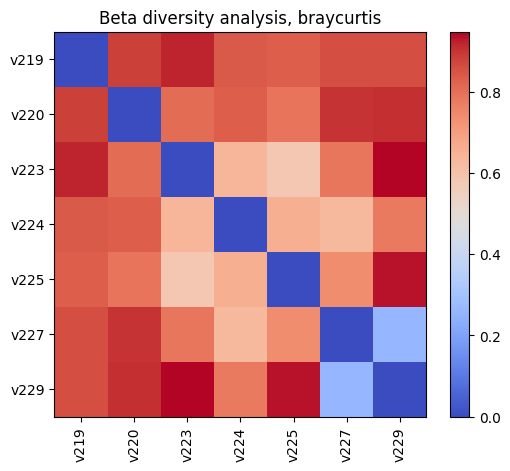

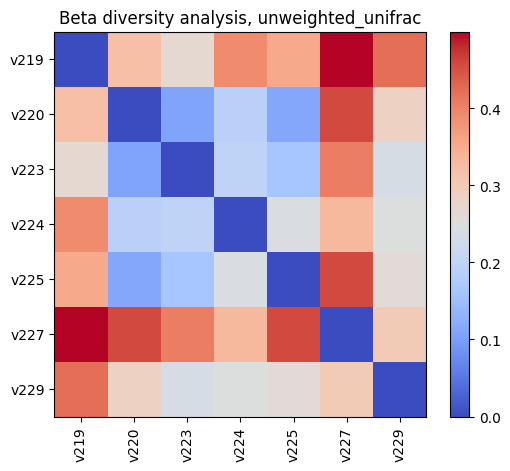

In [19]:
metrics = ["braycurtis", "unweighted_unifrac"]
# metric = metrics[0]
for metric in metrics:

    if "unifrac" in metric:
        dm = diversity.beta_diversity(metric, counts, counts.index, otu_ids=counts.columns, tree=tree)
    else:
        dm = diversity.beta_diversity(metric, counts, counts.index)
        
    fig = dm.plot("coolwarm", f"Beta diversity analysis, {metric}")  # Greys
    fig.set_size_inches((6, 5))
    plt.savefig(f"../figures/eugene/beta_{metric}.png")
    plt.savefig(f"../figures/eugene/beta_{metric}.pdf")
    plt.show()